In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm

In [3]:
df_raw = pd.read_csv(r"C:\Users\Shaaf\Desktop\Data Science\Practice Projects\Historical Product Demand.csv\Data\Historical Product Demand.csv", parse_dates=['Date'])

In [4]:
df_raw.dropna(inplace=True)

In [5]:
df_raw.isnull().sum()

Product_Code        0
Warehouse           0
Product_Category    0
Date                0
Order_Demand        0
dtype: int64

In [6]:
df_raw.duplicated().sum()

113064

In [7]:
duplicates = df_raw[df_raw.duplicated(keep=False)]

In [8]:
duplicates.sort_values(by='Date', inplace=True)

C:\Users\Shaaf\AppData\Local\Temp\ipykernel_12976\891377806.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  duplicates.sort_values(by='Date', inplace=True)


In [9]:
duplicates

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
10649,Product_0094,Whse_C,Category_019,2011-12-09,5000
10648,Product_0094,Whse_C,Category_019,2011-12-09,5000
127739,Product_0122,Whse_A,Category_021,2011-12-15,500
69479,Product_0122,Whse_A,Category_021,2011-12-15,500
50578,Product_0932,Whse_J,Category_006,2011-12-20,2000
...,...,...,...,...,...
996210,Product_1568,Whse_C,Category_019,2016-12-30,0
921384,Product_1316,Whse_J,Category_019,2017-01-06,10000
920147,Product_1970,Whse_J,Category_005,2017-01-06,2000
921345,Product_1316,Whse_J,Category_019,2017-01-06,10000


In [10]:
df_raw.drop_duplicates(inplace=True)

In [11]:
df_raw.reset_index(drop=True, inplace=True)

In [12]:
df_raw

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012-07-27,100
1,Product_0979,Whse_J,Category_028,2012-01-19,500
2,Product_0979,Whse_J,Category_028,2012-02-03,500
3,Product_0979,Whse_J,Category_028,2012-02-09,500
4,Product_0979,Whse_J,Category_028,2012-03-02,500
...,...,...,...,...,...
924267,Product_1759,Whse_J,Category_001,2016-11-10,2
924268,Product_1974,Whse_J,Category_006,2016-04-27,1
924269,Product_1787,Whse_J,Category_006,2016-04-28,2500
924270,Product_0901,Whse_J,Category_023,2016-10-07,50


In [13]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 924272 entries, 0 to 924271
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Product_Code      924272 non-null  object        
 1   Warehouse         924272 non-null  object        
 2   Product_Category  924272 non-null  object        
 3   Date              924272 non-null  datetime64[ns]
 4   Order_Demand      924272 non-null  object        
dtypes: datetime64[ns](1), object(4)
memory usage: 35.3+ MB


In [14]:
df_raw['Order_Demand'] = df_raw['Order_Demand'].str.replace(r'\D+','',regex=True).astype(int)

<Axes: xlabel='Order_Demand', ylabel='Count'>

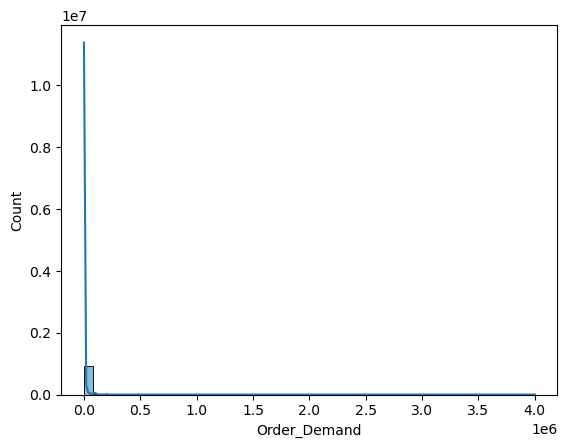

In [15]:
sns.histplot(data=df_raw, x='Order_Demand', bins=50, kde=True)

<Axes: xlabel='Order_Demand'>

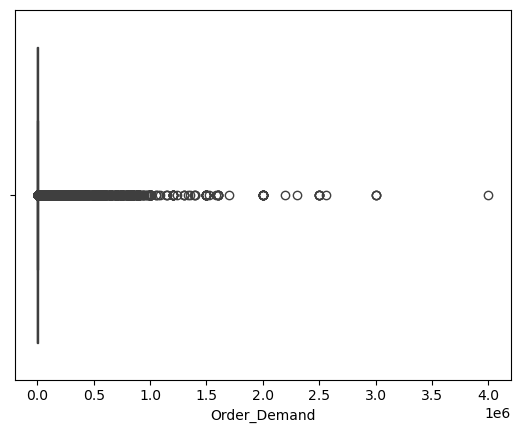

In [16]:
sns.boxplot(data=df_raw, x='Order_Demand')

<Axes: ylabel='Order_Demand'>

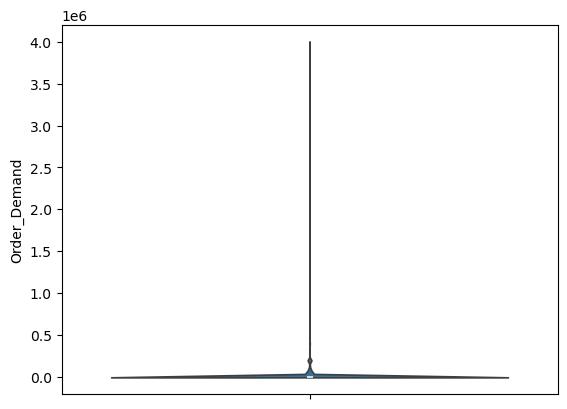

In [17]:
sns.violinplot(df_raw['Order_Demand'])

In [18]:
df_raw.sort_values(by='Order_Demand', ascending=False).head(10)

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
20202,Product_1432,Whse_S,Category_019,2012-06-11,4000000
67022,Product_1341,Whse_C,Category_019,2012-02-06,3000000
19795,Product_1248,Whse_J,Category_019,2012-07-05,3000000
198105,Product_1432,Whse_S,Category_019,2013-06-14,3000000
230938,Product_1248,Whse_J,Category_019,2013-11-11,2560000
579186,Product_1432,Whse_S,Category_019,2015-03-13,2500000
579190,Product_1432,Whse_S,Category_019,2015-05-19,2500000
97618,Product_1248,Whse_J,Category_019,2012-11-26,2500000
579195,Product_1432,Whse_S,Category_019,2015-10-09,2500000
767072,Product_1432,Whse_S,Category_019,2016-07-29,2500000


In [19]:
df_raw

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012-07-27,100
1,Product_0979,Whse_J,Category_028,2012-01-19,500
2,Product_0979,Whse_J,Category_028,2012-02-03,500
3,Product_0979,Whse_J,Category_028,2012-02-09,500
4,Product_0979,Whse_J,Category_028,2012-03-02,500
...,...,...,...,...,...
924267,Product_1759,Whse_J,Category_001,2016-11-10,2
924268,Product_1974,Whse_J,Category_006,2016-04-27,1
924269,Product_1787,Whse_J,Category_006,2016-04-28,2500
924270,Product_0901,Whse_J,Category_023,2016-10-07,50


In [20]:
df_raw['Product_Code'].value_counts()

Product_Code
Product_1359    10859
Product_1295     7255
Product_1378     6778
Product_1286     6258
Product_1382     6038
                ...  
Product_1912        2
Product_2099        1
Product_0465        1
Product_1703        1
Product_0853        1
Name: count, Length: 2160, dtype: int64

In [21]:
def get_data_by_product_code(data,Product_Code):
    df_product = data[data['Product_Code']==Product_Code]
    return df_product

In [22]:
data=get_data_by_product_code(df_raw,'Product_1359')

In [23]:
data=data[['Date','Order_Demand']]

In [24]:
data.sort_values(by='Date',inplace=True)

In [25]:
data.reset_index(drop=True,inplace=True)

In [26]:
data.set_index('Date',inplace=True)

In [27]:
data

,Order_Demand
Date,
2012-01-05,5000
2012-01-05,1000
2012-01-05,300000
2012-01-05,16000
2012-01-05,25000
...,...
2016-12-28,10000
2016-12-28,3000
2016-12-28,50000


In [28]:
data=pd.DataFrame(data.groupby(data.index)['Order_Demand'].sum(),columns=['Order_Demand'])

In [29]:
data

,Order_Demand
Date,
2012-01-05,659000
2012-01-06,567000
2012-01-10,633000
2012-01-11,113000
2012-01-12,183000
...,...
2016-12-22,165000
2016-12-26,277000
2016-12-27,39000


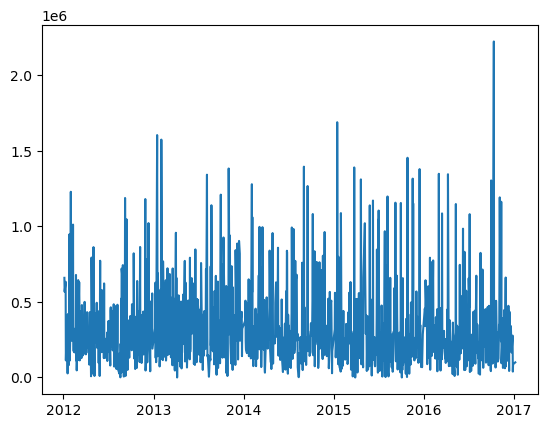

In [30]:
plt.plot(data)

In [31]:
df_resampled=data.resample('M').sum()

C:\Users\Shaaf\AppData\Local\Temp\ipykernel_12976\3265787247.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_resampled=data.resample('M').sum()


In [32]:
df_resampled

,Order_Demand
Date,
2012-01-31,7501000
2012-02-29,6618000
2012-03-31,6512000
2012-04-30,7041000
2012-05-31,7520000
...,...
2016-09-30,5780000
2016-10-31,6344000
2016-11-30,7278000


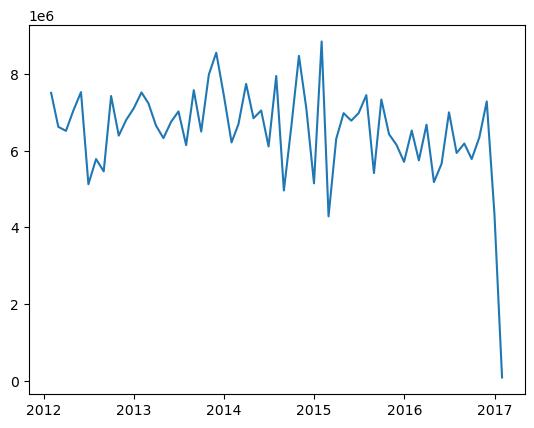

In [33]:
plt.plot(df_resampled)

In [34]:
results = seasonal_decompose(df_resampled, model='additive')

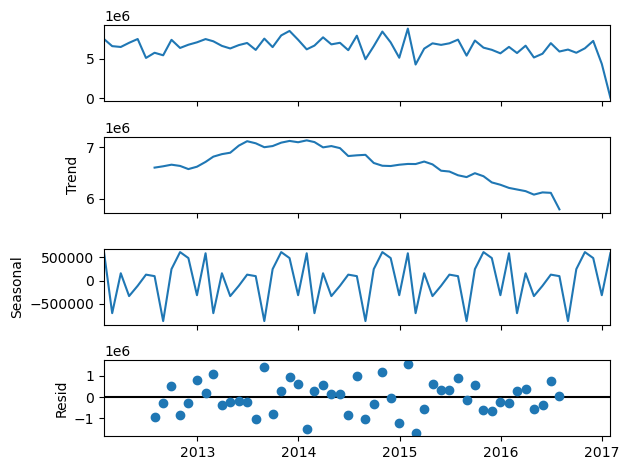

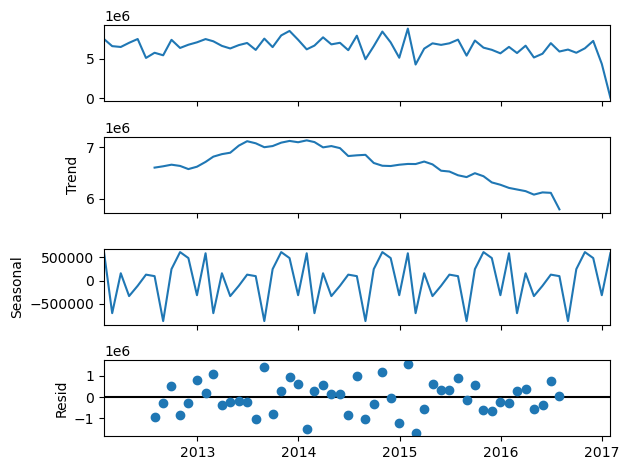

In [35]:
results.plot()

In [36]:
adf_test = adfuller(df_resampled['Order_Demand'])
adf_test

(-4.964501890694619,
 2.607774927248491e-05,
 0,
 60,
 {'1%': -3.5443688564814813,
  '5%': -2.9110731481481484,
  '10%': -2.5931902777777776},
 1524.9647818505953)

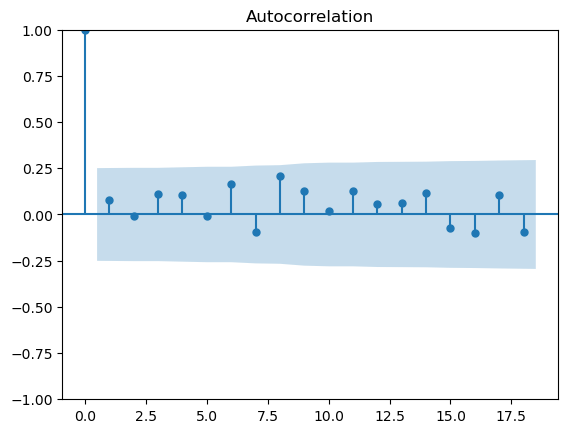

In [37]:
plot_acf(df_resampled)
plt.show()

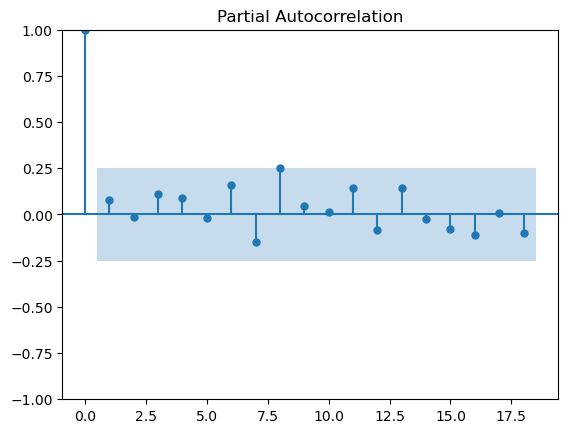

In [38]:
plot_pacf(df_resampled)
plt.show()

In [39]:
model=SARIMAX(df_resampled, order=(0,0,0), seasonal_order=(1,0,1,12))
model_fit=model.fit(disp=False)

In [40]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                  
==================================================================================
Dep. Variable:               Order_Demand   No. Observations:                   61
Model:             SARIMAX(1, 0, [1], 12)   Log Likelihood                -972.649
Date:                    Mon, 25 Aug 2025   AIC                           1951.298
Time:                            14:15:37   BIC                           1957.631
Sample:                        01-31-2012   HQIC                          1953.780
                             - 01-31-2017                                         
Covariance Type:                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.9838      0.020     48.613      0.000       0.944       1.024
ma.S.L12      -0.2817      0.247     -1.140      0.254      -0.766       0.203
sigma2      2.538e+12   1.27e-13   1.99e+25      0.000    2.54e+12    2.54e+12
===================================================================================
Ljung-Box (L1) (Q):                   1.38   Jarque-Bera (JB):                95.45
Prob(Q):                              0.24   Prob(JB):                         0.00
Heteroskedasticity (H):               1.49   Skew:                            -1.60
Prob(H) (two-sided):                  0.38   Kurtosis:                         8.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.76e+40. Standard errors may be unstable.
"""

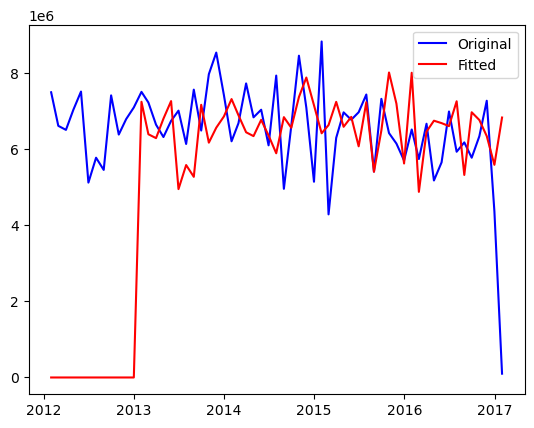

In [41]:
plt.plot(df_resampled,label='Original', color='blue')
plt.plot(model_fit.fittedvalues, label='Fitted', color='red')
plt.legend()

In [42]:
df_resampled

,Order_Demand
Date,
2012-01-31,7501000
2012-02-29,6618000
2012-03-31,6512000
2012-04-30,7041000
2012-05-31,7520000
...,...
2016-09-30,5780000
2016-10-31,6344000
2016-11-30,7278000


In [43]:
df_resampled=df_resampled.diff(12).dropna()

In [44]:
# df_resampled=np.log1p(df_resampled)

In [45]:
df_resampled

,Order_Demand
Date,
2013-01-31,11000.0
2013-02-28,614000.0
2013-03-31,137000.0
2013-04-30,-717000.0
2013-05-31,-771000.0
2013-06-30,1893000.0
2013-07-31,361000.0
2013-08-31,2111000.0
2013-09-30,-924000.0


In [46]:
model_auto=pm.auto_arima(df_resampled, start_p=0, max_p=5, start_q=0, max_q=5, start_P=0,max_P=5,start_Q=0,max_Q=5, seasonal=True, m=12, trace=True, error_action='ignore', suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1540.320, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1527.499, Time=0.03 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1516.292, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1538.515, Time=0.00 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=1518.574, Time=0.01 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=1517.781, Time=0.03 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=1517.953, Time=0.06 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=1516.682, Time=0.02 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=1531.394, Time=0.02 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=1516.206, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=1517.248, Time=0.02 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=1517.816, Time=0.05 sec
 ARIMA(1,1,1)(0,0,2)[12] intercept   : AIC=1517.884, Time=0.07 sec
 ARIMA(1,1,1)(1,0,0)[12]

In [47]:
sari_max_model=SARIMAX(df_resampled, order=model_auto.order, seasonal_order=model_auto.seasonal_order)
sari_max_model_fit=sari_max_model.fit(disp=False)

c:\Users\Shaaf\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


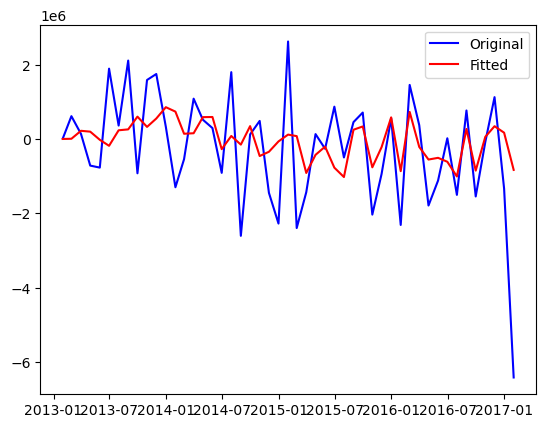

In [48]:
#plot actual vs fitted
plt.plot(df_resampled,label='Original', color='blue')  
plt.plot(sari_max_model_fit.fittedvalues, label='Fitted', color='red')
plt.legend()

In [49]:
data

,Order_Demand
Date,
2012-01-05,659000
2012-01-06,567000
2012-01-10,633000
2012-01-11,113000
2012-01-12,183000
...,...
2016-12-22,165000
2016-12-26,277000
2016-12-27,39000


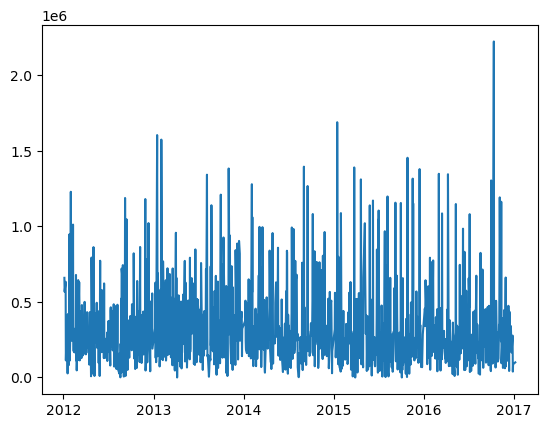

In [50]:
plt.plot(data)

In [51]:
data_log=np.log1p(data)

In [52]:
data_log

,Order_Demand
Date,
2012-01-05,13.398480
2012-01-06,13.248116
2012-01-10,13.358227
2012-01-11,11.635152
2012-01-12,12.117247
...,...
2016-12-22,12.013707
2016-12-26,12.531776
2016-12-27,10.571343


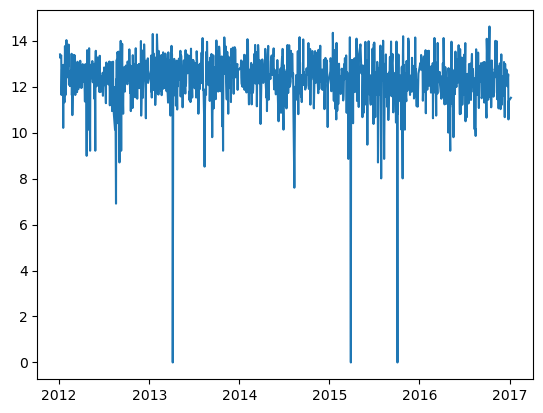

In [53]:
plt.plot(data_log)

In [54]:
data_log.sort_values(by='Order_Demand').head(10)

,Order_Demand
Date,
2015-10-04,0.000000
2013-04-06,0.000000
2015-03-29,0.000000
2012-08-19,6.908755
2014-08-12,7.601402
2015-07-30,8.006701
2015-10-25,8.006701
2014-08-11,8.517393
2013-08-13,8.517393


In [55]:
data_log_resampled=data_log.resample('ME').sum()

In [57]:
data_log_resampled

,Order_Demand
Date,
2012-01-31,227.024489
2012-02-29,261.608075
2012-03-31,262.728933
2012-04-30,306.534139
2012-05-31,284.481093
...,...
2016-09-30,245.082689
2016-10-31,256.427019
2016-11-30,249.630079


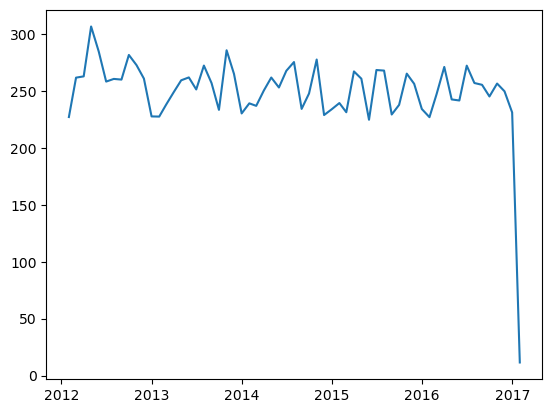

In [56]:
plt.plot(data_log_resampled)

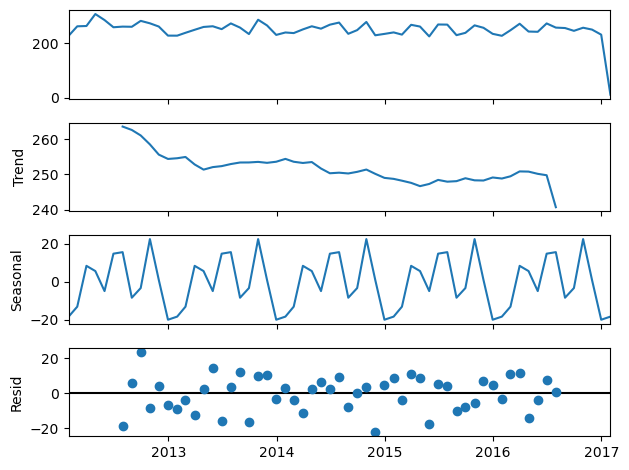

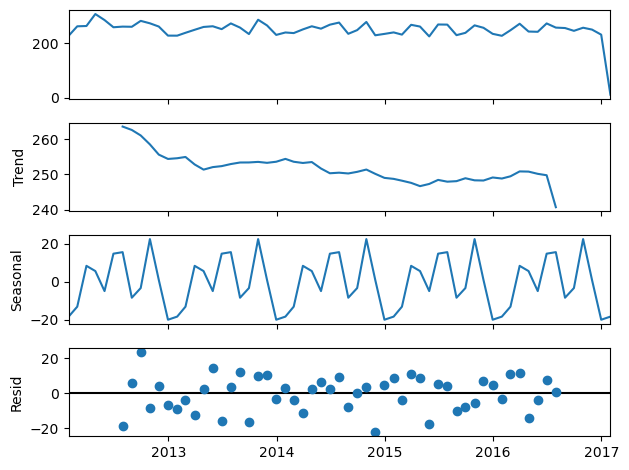

In [59]:
results = seasonal_decompose(data_log_resampled, model='additive', period=12)
results.plot()

In [60]:
data_log_resampled['First Difference']=data_log_resampled['Order_Demand'].diff(12).dropna()

In [62]:
data_log_resampled.dropna(inplace=True)

In [63]:
data_log_resampled

,Order_Demand,First Difference
Date,,
2013-01-31,227.418787,0.394298
2013-02-28,237.906844,-23.701231
2013-03-31,248.945931,-13.783002
2013-04-30,259.280172,-47.253967
2013-05-31,261.806110,-22.674983
2013-06-30,251.244559,-6.910265
2013-07-31,272.208691,11.717061
2013-08-31,256.856915,-3.048292
2013-09-30,233.313221,-48.226662


In [64]:
adf_test = adfuller(data_log_resampled['First Difference'])
adf_test

(-1.922320091266053,
 0.32163497605552216,
 4,
 44,
 {'1%': -3.5885733964124715,
  '5%': -2.929885661157025,
  '10%': -2.6031845661157025},
 376.4463177634498)

In [65]:
data_log_resampled['Second Difference']=data_log_resampled['First Difference'].diff(12).dropna()

In [67]:
data_log_resampled.dropna(inplace=True)

In [68]:
adf_test = adfuller(data_log_resampled['Second Difference'])
adf_test


(-3.329372660307308,
 0.013615493305393335,
 0,
 36,
 {'1%': -3.626651907578875,
  '5%': -2.9459512825788754,
  '10%': -2.6116707716049383},
 275.3359222064208)

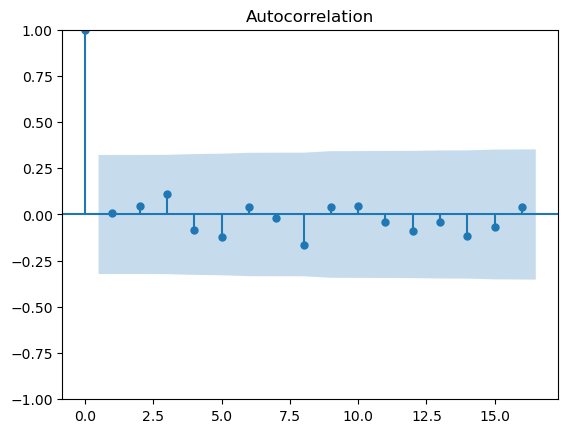

In [69]:
plot_acf(data_log_resampled['Second Difference'])
plt.show()

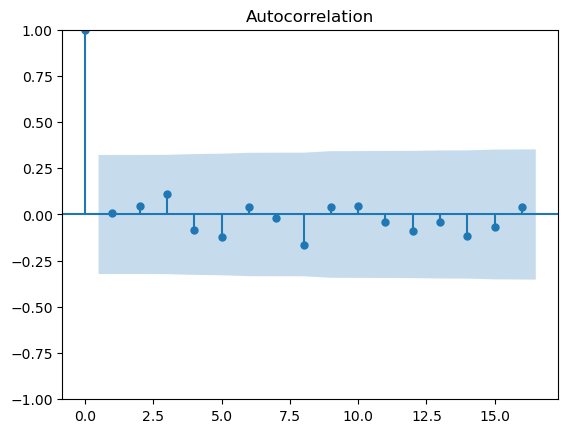

In [70]:
plot_acf(data_log_resampled['Second Difference'])
plt.show()

In [72]:
model=pm.auto_arima(data_log_resampled['Order_Demand'], start_p=0, max_p=5, start_q=0, max_q=5, start_P=0,max_P=5,start_Q=0,max_Q=5, seasonal=True, m=12, trace=True, error_action='ignore', suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=264.256, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=268.229, Time=0.08 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=268.226, Time=0.08 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=263.281, Time=0.01 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=266.236, Time=0.07 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=266.232, Time=0.03 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=266.247, Time=0.02 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=266.247, Time=0.03 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=268.227, Time=0.04 sec

Best model:  ARIMA(0,0,0)(0,1,0)[12]          
Total fit time: 0.505 seconds


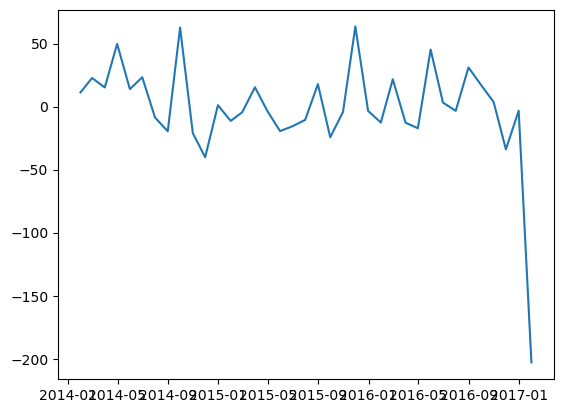

In [73]:
plt.plot(data_log_resampled['Second Difference'])

In [75]:
import pmdarima as pm

model = pm.auto_arima(
    data_log_resampled['Second Difference'],
    start_p=0, start_q=0,
    max_p=5, max_q=5,
    seasonal=True,
    m=12,      # seasonal period (12 for monthly data)
    d=None,    # auto_arima finds optimal non-seasonal differencing
    D=None,    # auto_arima finds optimal seasonal differencing
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

print(model.summary())


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=387.521, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=384.473, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=387.792, Time=0.03 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=387.931, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=382.521, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=385.795, Time=0.03 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=385.936, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=386.468, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=386.469, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=387.911, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12]          
Total fit time: 0.383 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   37
Model:                        SARIMAX   Log Likelihood       

In [77]:
model=SARIMAX(data_log_resampled['Order_Demand'], order=(0,0,0), seasonal_order=(0,1,0,12))
model_fit=model.fit(disp=False)

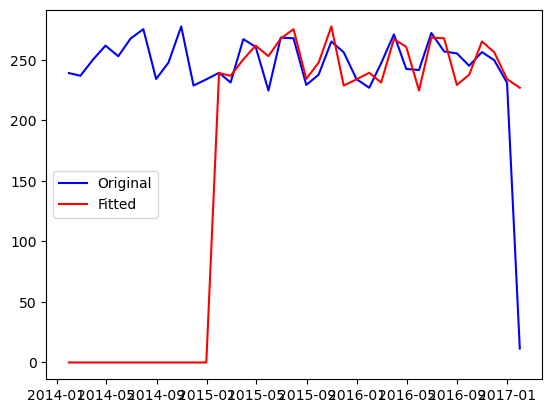

In [78]:
plt.plot(data_log_resampled['Order_Demand'], label='Original', color='blue')
plt.plot(model_fit.fittedvalues, label='Fitted', color='red')
plt.legend()